# Label Procesing and Exploration

In [1]:
import csv
from os import listdir
from os.path import exists

from scipy import stats
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

### Read in HBN CSV File

In [3]:
from common.paths import RAW_WISC

raw_labels = pd.read_csv(RAW_WISC, index_col='Identifiers', dtype='str')
num_raw_subjects = raw_labels['assessment WISC,EID'].nunique()

print(f'Number of labels: {num_raw_subjects}')

Number of labels: 2936


### Read in Functional Connectivities

In [4]:
import glob

from common.paths import POWER_FC
from common.data import get_subject_id_from_path

fc_paths = glob.glob(POWER_FC + f'/**/power_fc.npy', recursive=True)
data_subject_ids = {get_subject_id_from_path(path) for path in fc_paths}
data = pd.DataFrame(data_subject_ids, columns=['subject_id']).set_index('subject_id')

print(f'Number of FCs: {len(data)}')

Number of FCs: 880


## Clean labels

### Filter for basic demographics, diagnosis, and WISC

In [5]:
demographics = raw_labels[['assessment Basic_Demos,Sex', 'assessment Basic_Demos,Age']]
has_diagnosis_col = 'assessment Diagnosis_ClinicianConsensus,NoDX'
actual_diagnosis_col = [
    'assessment Diagnosis_ClinicianConsensus,DX_01',
    'assessment Diagnosis_ClinicianConsensus,DX_02',
    'assessment Diagnosis_ClinicianConsensus,DX_03',
    'assessment Diagnosis_ClinicianConsensus,DX_04',
    'assessment Diagnosis_ClinicianConsensus,DX_05',
    'assessment Diagnosis_ClinicianConsensus,DX_06',
    'assessment Diagnosis_ClinicianConsensus,DX_07',
    'assessment Diagnosis_ClinicianConsensus,DX_08',
    'assessment Diagnosis_ClinicianConsensus,DX_09',
    'assessment Diagnosis_ClinicianConsensus,DX_10',
]
diagnosis_cols = [has_diagnosis_col] + actual_diagnosis_col
diagnosis = raw_labels[diagnosis_cols]

labels = raw_labels.filter(like="WISC").join(demographics).join(diagnosis)
labels = labels[labels['assessment WISC,WISC_complete'] == '1']
labels = labels.set_index("assessment WISC,EID")

unused_wisc_col = [
    'assessment WISC,Administration', 
    'assessment WISC,Comment_ID', 
    'assessment WISC,Days_Baseline',
    'assessment WISC,PSCID',
    'assessment WISC,START_DATE',
    'assessment WISC,Season',
    'assessment WISC,Site',
    'assessment WISC,Study',
    'assessment WISC,Visit_label',
]
labels = labels.drop(columns=unused_wisc_col)

print(f'Number of subjects with complete WISC: {len(labels)}')

Number of subjects with complete WISC: 2751


### Get the list of bad subjects and remove them

In [6]:
from common.paths import BAD_SUBJECTS

bad_subjects = pd.read_csv(BAD_SUBJECTS, index_col='subject_id')
print("Number of bad subjects:", len(bad_subjects))

clean_labels = labels[~labels.index.isin(bad_subjects.index)]
print("Number of clean subjects:", len(clean_labels))

Number of bad subjects: 178
Number of clean subjects: 2609


### Filter for subjects with FC data

In [7]:
subjects_with_labels = clean_labels.merge(data, left_index=True, right_index=True)
subjects_with_labels.index.rename("assessment WISC,EID", inplace=True)

print(f'Number of subjects with labels + FC: {len(subjects_with_labels)}')
print(f'Number of labels: {len(subjects_with_labels.columns)}')

Number of subjects with labels + FC: 726
Number of labels: 55


### Filter by IQ

In [8]:
wisc_iq_col = 'assessment WISC,WISC_FSIQ'
subjects_with_labels[wisc_iq_col] = subjects_with_labels[wisc_iq_col].astype('int32')
subjects_with_labels = subjects_with_labels[subjects_with_labels[wisc_iq_col] >= 70]

print(f'Number of subjects: {len(subjects_with_labels)}')

Number of subjects: 708


### Clean up diagnosis column and filter for subjects with/without diagnosis

In [20]:
given_diagnosis = subjects_with_labels[has_diagnosis_col]
filter_diagnosis = 'Yes'
# filter_diagnosis = 'No'

# 1= No, 2= Yes, 3= Dropped out of study before diagnosis was given
diagnosis_key = {'1': 'No', '2': 'Yes', '3': 'Unknown', '.': 'Unknown'}
subjects_with_labels[has_diagnosis_col] = given_diagnosis.replace(diagnosis_key)
subjects_diagnosis = subjects_with_labels[subjects_with_labels[has_diagnosis_col] == filter_diagnosis]
subjects_diagnosis = subjects_diagnosis.drop_duplicates()

print(f'Number of subjects with "{filter_diagnosis}" diagnosis: {len(subjects_diagnosis)}')

Number of subjects with "Yes" diagnosis: 571


### Filter for ADHD subjects

In [21]:
adhd_subjects = subjects_diagnosis[actual_diagnosis_col].apply(
    lambda x: x.str.contains('ADHD', regex=False))
adhd_subjects = adhd_subjects.any(axis='columns')
subjects_with_adhd = subjects_diagnosis[adhd_subjects].sample(frac=1)

print(f'Number of subjects with ADHD: {len(subjects_with_adhd)}')

Number of subjects with ADHD: 373


In [13]:
# Sample a subset
# adhd_subset = subjects_with_adhd.iloc[190:]
adhd_subset = subjects_with_adhd.sample(n=93)

print(f'Number of subjects in ADHD subset: {len(adhd_subset)}')

Number of subjects in ADHD subset: 93


### Filter for non-comorbid ADHD subjects

In [69]:
subjects_with_labels = subjects_with_labels[subjects_with_labels['assessment Diagnosis_ClinicianConsensus,DX_02'].isnull()]
subjects_with_labels = subjects_with_labels[subjects_with_labels['assessment Diagnosis_ClinicianConsensus,DX_01'].str.contains('ADHD', regex=False)]
print(f'Number of subjects with only ADHD: {len(subjects_with_labels)}')

Number of subjects with only ADHD: 65


## Write labels to CSV

In [10]:
from common.paths import HEALTHY, ADHD

subjects = subjects_with_adhd
# subjects = adhd_subset
# subjects = subjects_diagnosis
subjects.to_csv(ADHD)

print(f'Number of labels written: {len(subjects)}')
print(subjects.columns)

Number of labels written: 373
Index(['assessment WISC,Data_entry', 'assessment WISC,WISC_BD_Raw',
       'assessment WISC,WISC_BD_Scaled', 'assessment WISC,WISC_Coding_Raw',
       'assessment WISC,WISC_Coding_Scaled', 'assessment WISC,WISC_DS_Raw',
       'assessment WISC,WISC_DS_Scaled', 'assessment WISC,WISC_FRI',
       'assessment WISC,WISC_FRI_Percentile', 'assessment WISC,WISC_FRI_Sum',
       'assessment WISC,WISC_FSIQ', 'assessment WISC,WISC_FSIQ_Percentile',
       'assessment WISC,WISC_FSIQ_Sum', 'assessment WISC,WISC_FW_Raw',
       'assessment WISC,WISC_FW_Scaled', 'assessment WISC,WISC_MR_Raw',
       'assessment WISC,WISC_MR_Scaled', 'assessment WISC,WISC_PSI',
       'assessment WISC,WISC_PSI_Percentile', 'assessment WISC,WISC_PSI_Sum',
       'assessment WISC,WISC_PS_Raw', 'assessment WISC,WISC_PS_Scaled',
       'assessment WISC,WISC_SS_Raw', 'assessment WISC,WISC_SS_Scaled',
       'assessment WISC,WISC_Similarities_Raw',
       'assessment WISC,WISC_Similarities_Sca

## Get dataset statistics

In [18]:
from common.binning import get_age_bins_indices, BIN_LABELS
from common.wisc import WISC_LEVEL

def get_stats(data):
    lowest, highest = np.min(data), np.max(data)
    mean, std = np.mean(data), np.std(data)
    stats = f'{mean:.2f} ({std:.2f}) | {lowest:.2f} to {highest:.2f}'
    
    return stats

### ADHD

In [24]:
bin_indices = get_age_bins_indices(
    subjects_with_adhd['assessment Basic_Demos,Age'].astype('float32'), 3)
bin_data = [subjects_with_adhd]

for index in bin_indices:
    bin_data.append(subjects_with_adhd.iloc[index])

for bin_label, bin_df in zip(BIN_LABELS, bin_data):
    print(f'{bin_label} Statistics')
    print(f'n={len(bin_df)}')
    
    sex_key = {'0': 'Male', '1': 'Female'}
    sex = bin_df['assessment Basic_Demos,Sex'].replace(sex_key).value_counts()
    print(f'Sex: {sex.to_dict()}')
    
    bin_age = bin_df['assessment Basic_Demos,Age'].astype('float32')
    print(f'Age: {get_stats(bin_age)}')
    
    for wisc_measure in WISC_LEVEL[5]:
        wisc_measure_data = bin_df[f'assessment WISC,{wisc_measure}'].astype('float32')
        print(f'{wisc_measure}: {get_stats(wisc_measure_data)}')
        
    print('---')

All Statistics
n=373
Sex: {'Male': 274, 'Female': 99}
Age: 10.57 (2.53) | 6.03 to 15.98
WISC_FSIQ: 100.13 (16.31) | 70.00 to 147.00
WISC_VSI: 102.32 (17.12) | 57.00 to 155.00
WISC_VCI: 105.04 (15.87) | 70.00 to 155.00
WISC_FRI: 101.33 (16.19) | 67.00 to 144.00
WISC_WMI: 98.54 (15.18) | 62.00 to 138.00
WISC_PSI: 93.65 (15.35) | 53.00 to 148.00
---
Bin 1 Statistics
n=114
Sex: {'Male': 77, 'Female': 37}
Age: 7.73 (0.76) | 6.03 to 8.98
WISC_FSIQ: 104.13 (15.47) | 73.00 to 138.00
WISC_VSI: 106.38 (16.64) | 67.00 to 147.00
WISC_VCI: 108.53 (16.06) | 70.00 to 146.00
WISC_FRI: 104.58 (15.40) | 67.00 to 140.00
WISC_WMI: 99.53 (14.83) | 67.00 to 138.00
WISC_PSI: 97.33 (15.29) | 56.00 to 148.00
---
Bin 2 Statistics
n=147
Sex: {'Male': 118, 'Female': 29}
Age: 10.34 (0.88) | 9.04 to 11.96
WISC_FSIQ: 98.56 (15.90) | 70.00 to 141.00
WISC_VSI: 100.73 (16.69) | 64.00 to 144.00
WISC_VCI: 104.44 (15.34) | 70.00 to 155.00
WISC_FRI: 99.14 (15.75) | 67.00 to 134.00
WISC_WMI: 97.21 (14.04) | 65.00 to 138.00


### Healthy

In [19]:
print('Healthy Statistics')
print(f'n={len(subjects_diagnosis)}')

sex_key = {'0': 'Male', '1': 'Female'}
sex = subjects_diagnosis['assessment Basic_Demos,Sex'].replace(sex_key).value_counts()
print(f'Sex: {sex.to_dict()}')

bin_age = subjects_diagnosis['assessment Basic_Demos,Age'].astype('float32')
print(f'Age: {get_stats(bin_age)}')

for wisc_measure in WISC_LEVEL[5]:
    wisc_measure_data = subjects_diagnosis[f'assessment WISC,{wisc_measure}'].astype('float32')
    print(f'{wisc_measure}: {get_stats(wisc_measure_data)}')

Healthy Statistics
n=106
Sex: {'Male': 62, 'Female': 44}
Age: 10.12 (2.78) | 6.05 to 16.50
WISC_FSIQ: 108.58 (14.20) | 76.00 to 145.00
WISC_VSI: 105.21 (15.01) | 64.00 to 141.00
WISC_VCI: 110.58 (13.93) | 78.00 to 155.00
WISC_FRI: 107.42 (15.11) | 69.00 to 155.00
WISC_WMI: 103.92 (14.29) | 72.00 to 135.00
WISC_PSI: 106.55 (15.80) | 66.00 to 155.00


## Checks

### Check Subjects with Diagnosis

Diagnosis Status


Yes        595
No          51
Unknown     32
Name: assessment Diagnosis_ClinicianConsensus,NoDX, dtype: int64

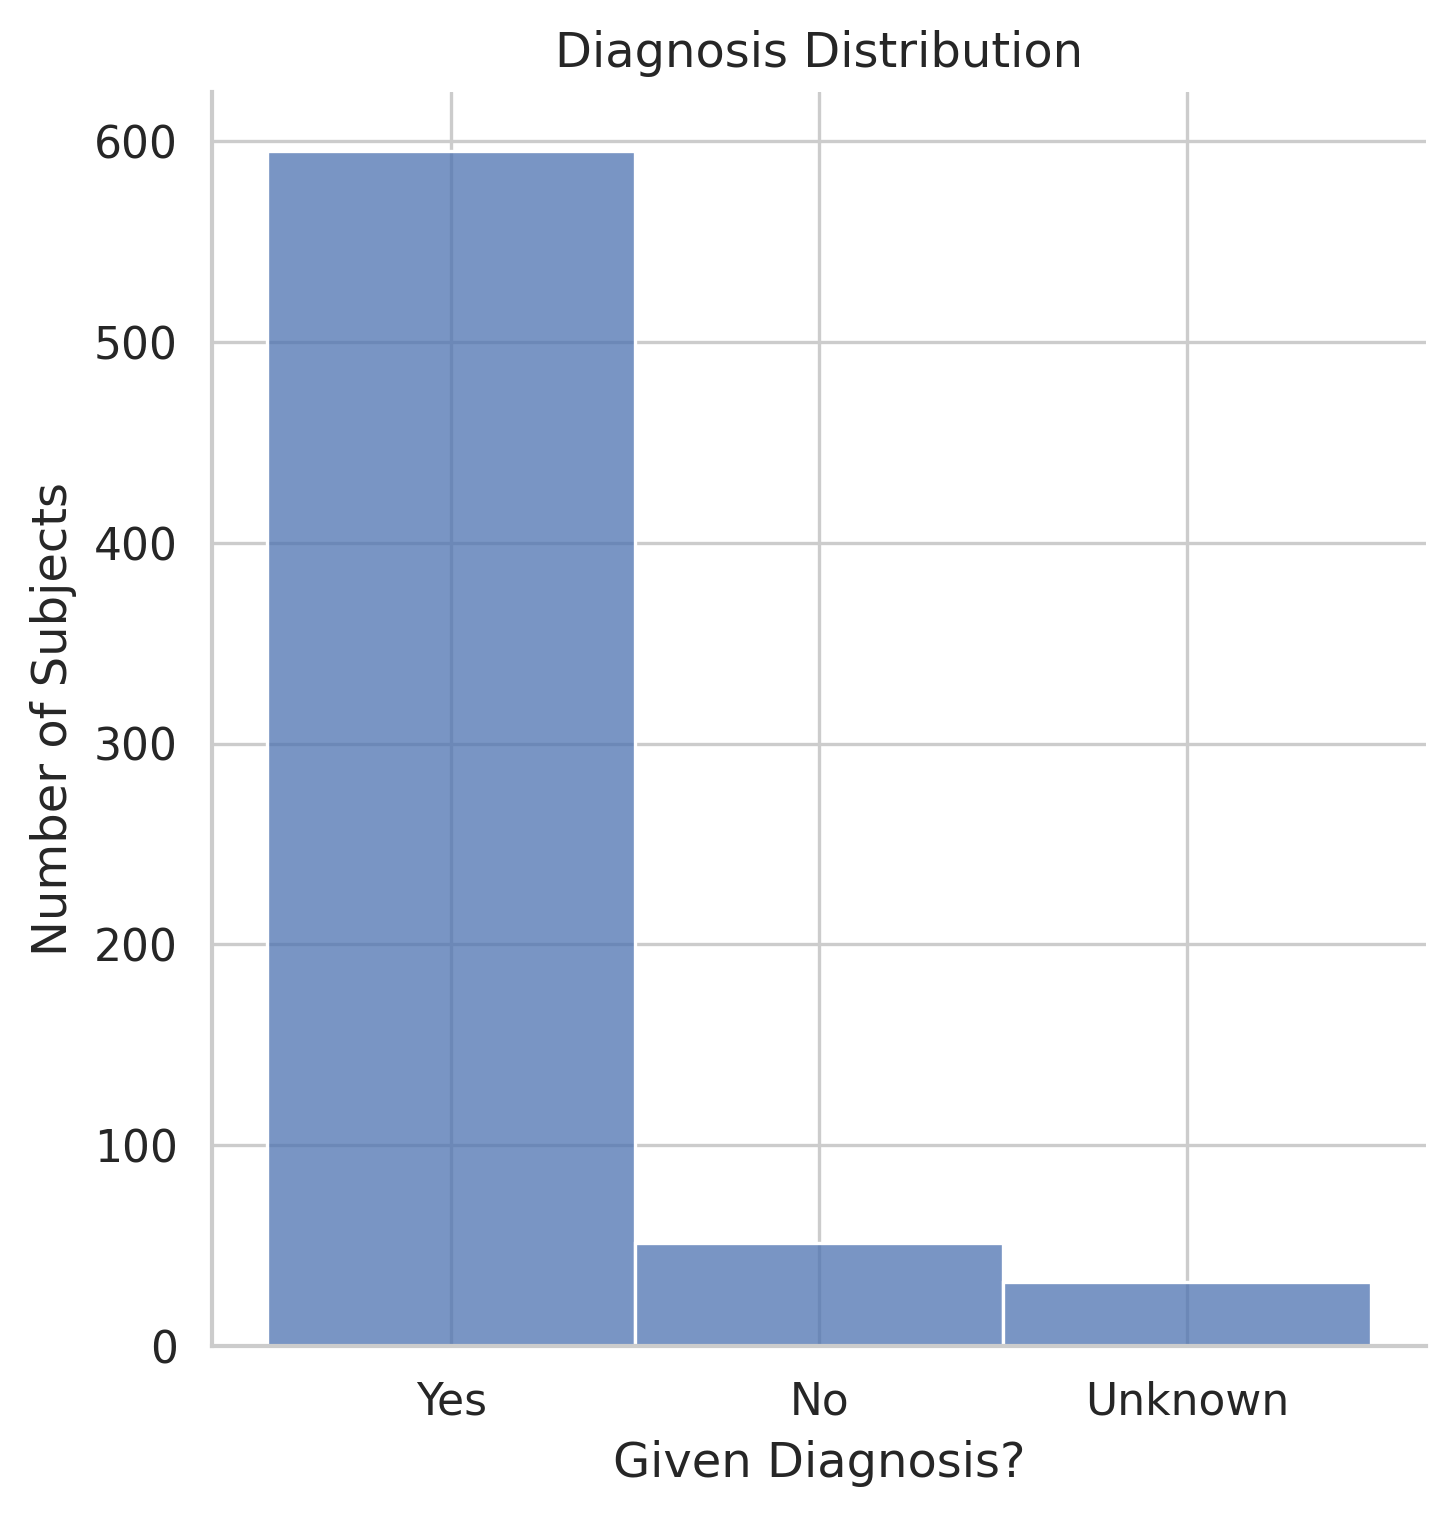

In [8]:
given_diagnosis_counts = given_diagnosis.value_counts()

print("Diagnosis Status")
display(given_diagnosis_counts)

sns.displot(given_diagnosis)
plt.title("Diagnosis Distribution")
plt.xlabel('Given Diagnosis?')
plt.ylabel('Number of Subjects')
plt.show()

Diagnosis


ADHD-Inattentive Type                                    208
ADHD-Combined Type                                       162
Specific Learning Disorder with Impairment in Reading    154
Generalized Anxiety Disorder                             106
Autism Spectrum Disorder                                  87
                                                        ... 
Binge-Eating Disorder                                      1
Illness Anxiety Disorder                                   1
Other Specified Tic Disorder                               1
Schizophrenia                                              1
Tobacco Use Disorder                                       1
Length: 66, dtype: int64

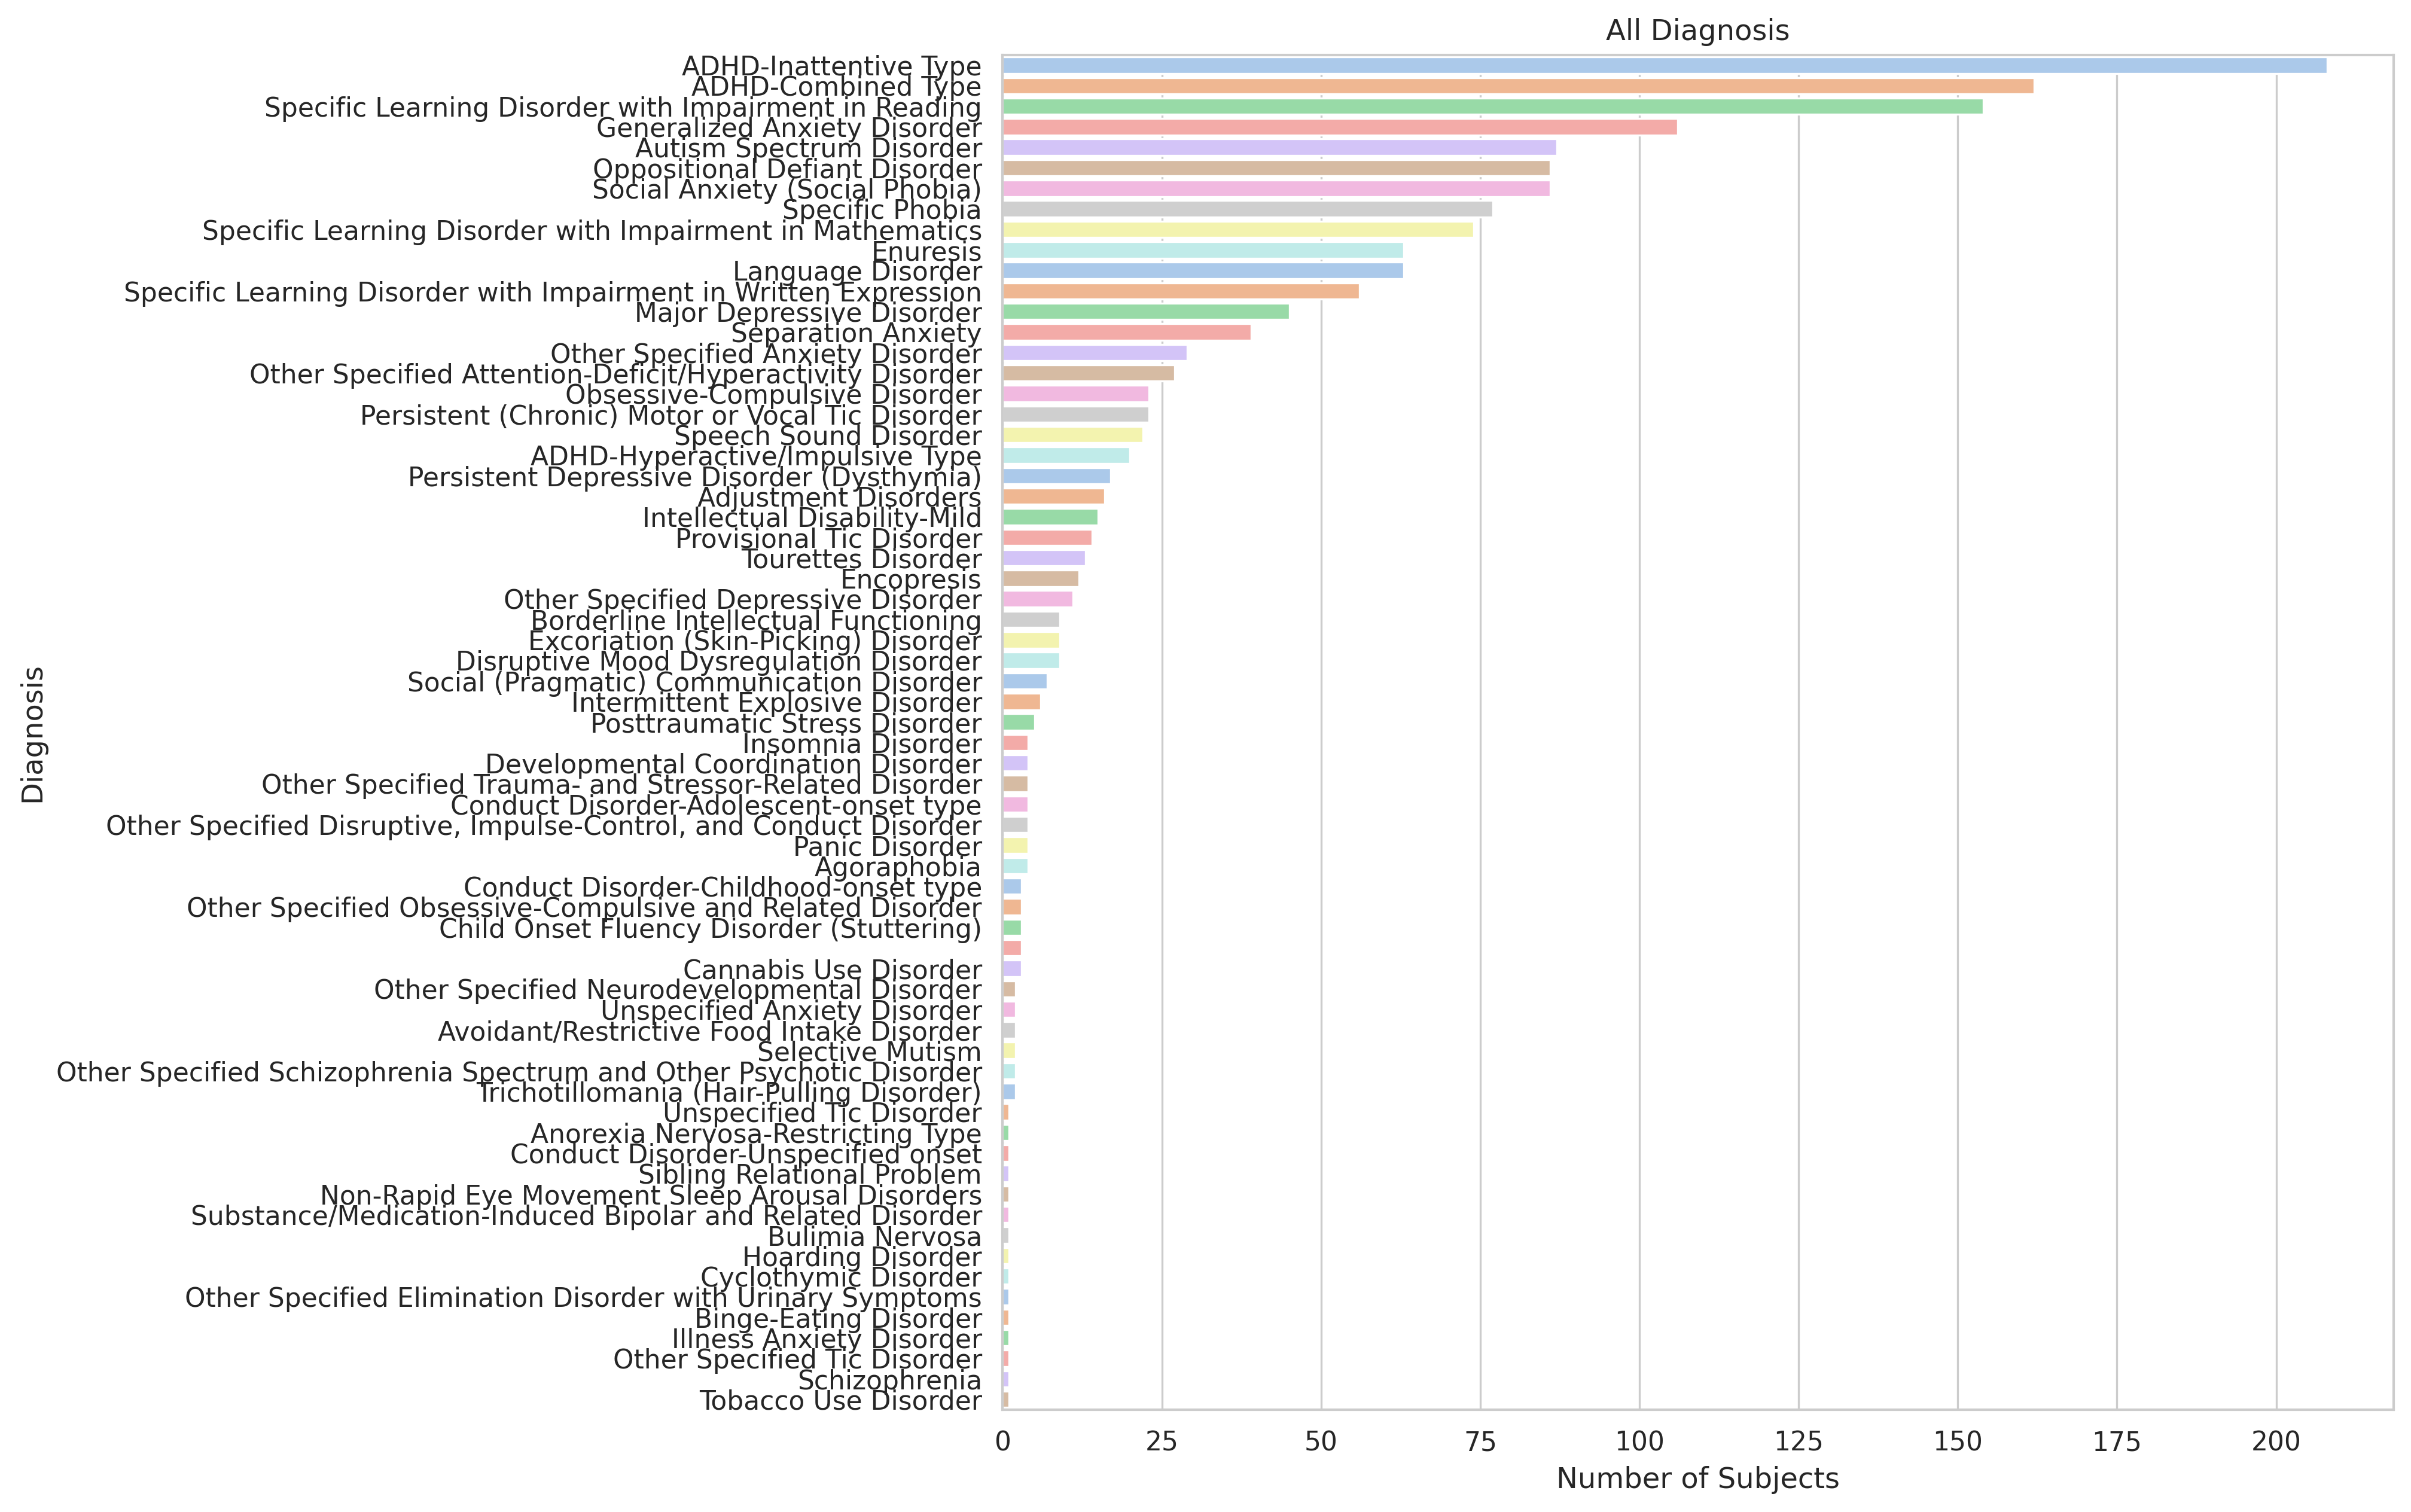

In [53]:
diagnosis = subjects_with_labels[actual_diagnosis_col].stack()
diagnosis_counts = diagnosis.value_counts()
# top_ten_diagnosis_counts = diagnosis_counts[:10]
top_ten_diagnosis_counts = diagnosis_counts

print("Diagnosis")
display(diagnosis_counts)

sns.barplot(x=top_ten_diagnosis_counts.values, y=top_ten_diagnosis_counts.index, 
            palette="pastel")
plt.title("All Diagnosis")
plt.xlabel('Number of Subjects')
plt.ylabel('Diagnosis')
plt.show()

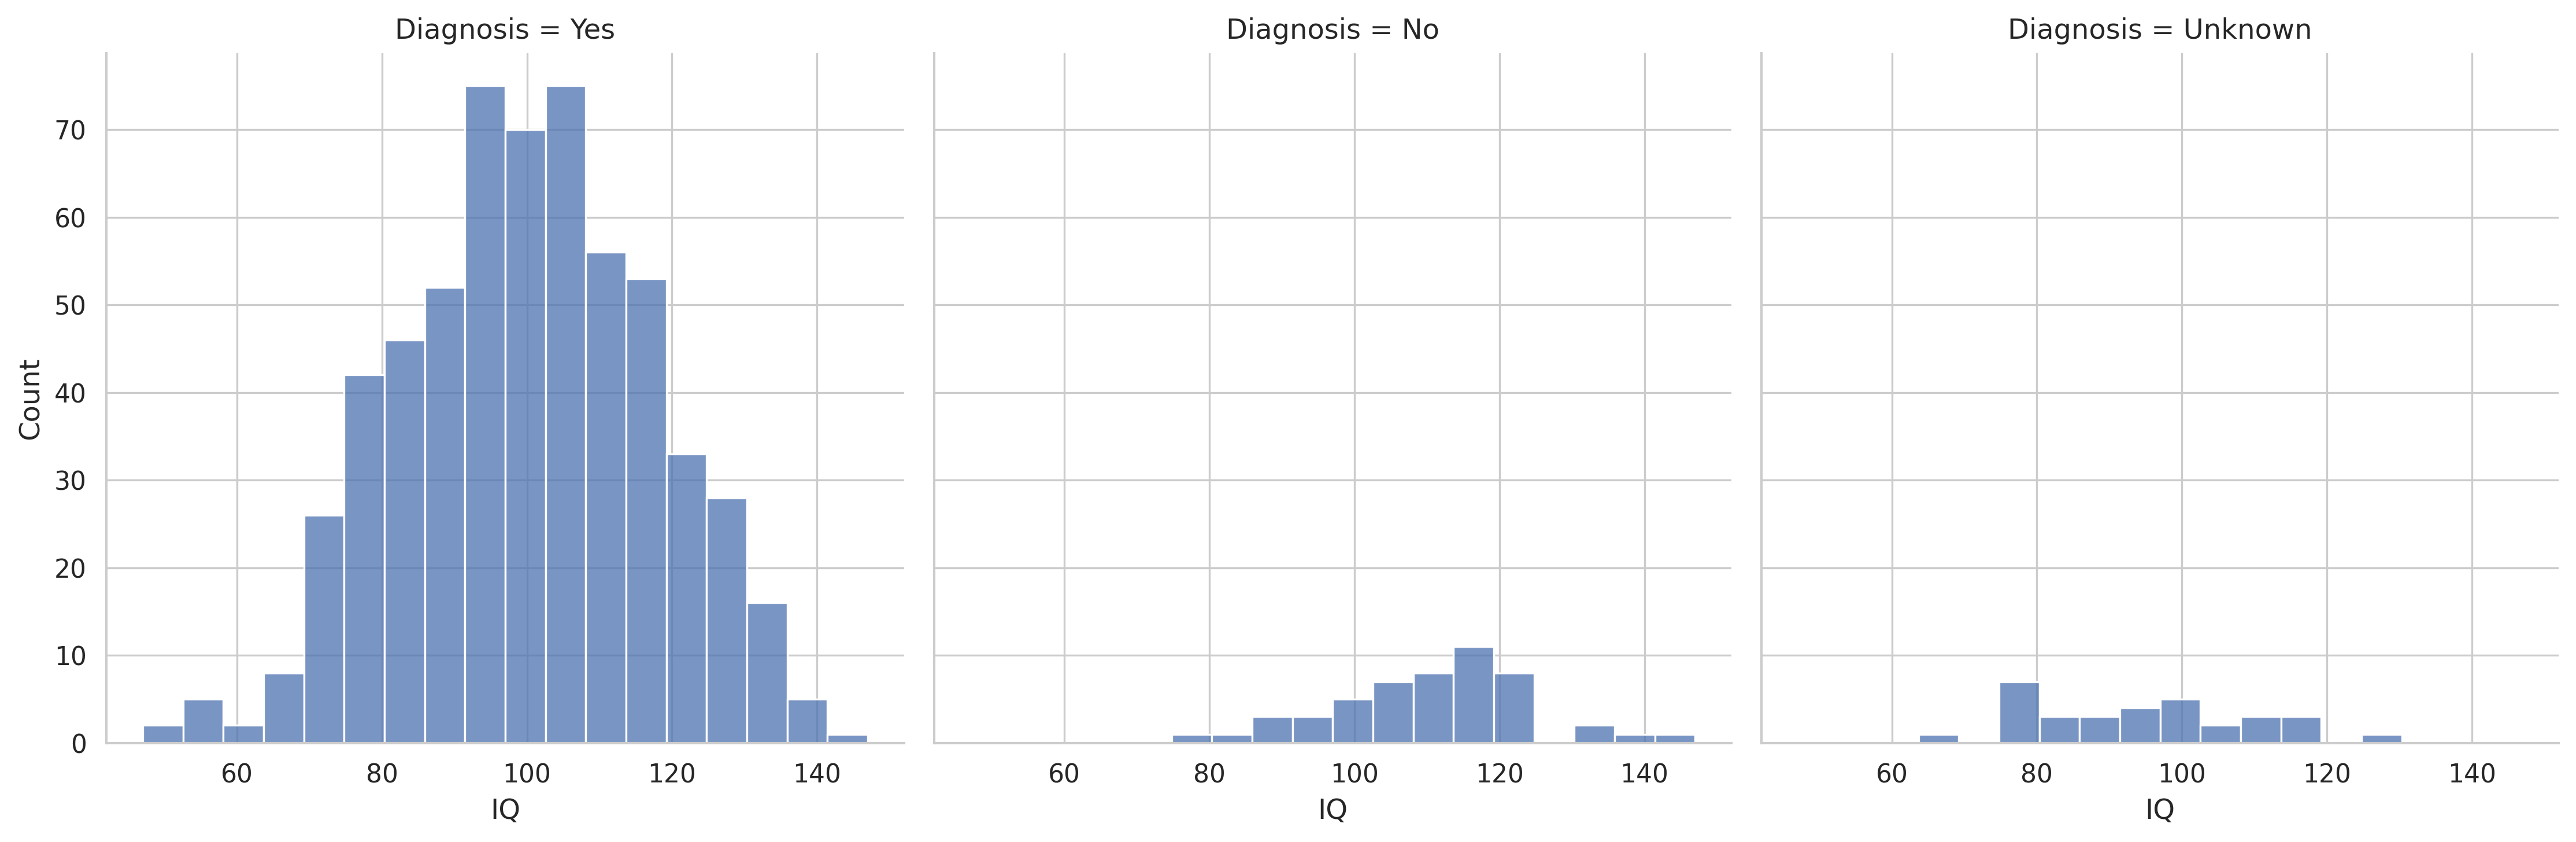

In [18]:
diagnosis_iq = subjects_with_labels[['assessment Diagnosis_ClinicianConsensus,NoDX', 
                                     'assessment WISC,WISC_FSIQ']]
diagnosis_iq = diagnosis_iq.rename(columns={'assessment Diagnosis_ClinicianConsensus,NoDX': 'Diagnosis',
                                    'assessment WISC,WISC_FSIQ': 'IQ'}, errors="raise")
diagnosis_iq['IQ'] = diagnosis_iq['IQ'].astype('int32')
# display(diagnosis_iq)

sns.displot(diagnosis_iq, x="IQ", col="Diagnosis", facet_kws=dict(margin_titles=True))
plt.show()

### Check WISC FSIQ against age

In [19]:
# Clean the original set of labels
clean_labels = labels[labels['assessment Basic_Demos,Age'] != "."]
clean_labels = clean_labels[clean_labels['assessment WISC,WISC_complete'] == '1']
clean_labels = clean_labels.dropna(axis='columns', how='all')

(2750,) (2750,) Avg IQ: 98.20472727272727
Slope: -0.69, r2: 0.01, p: 0.00


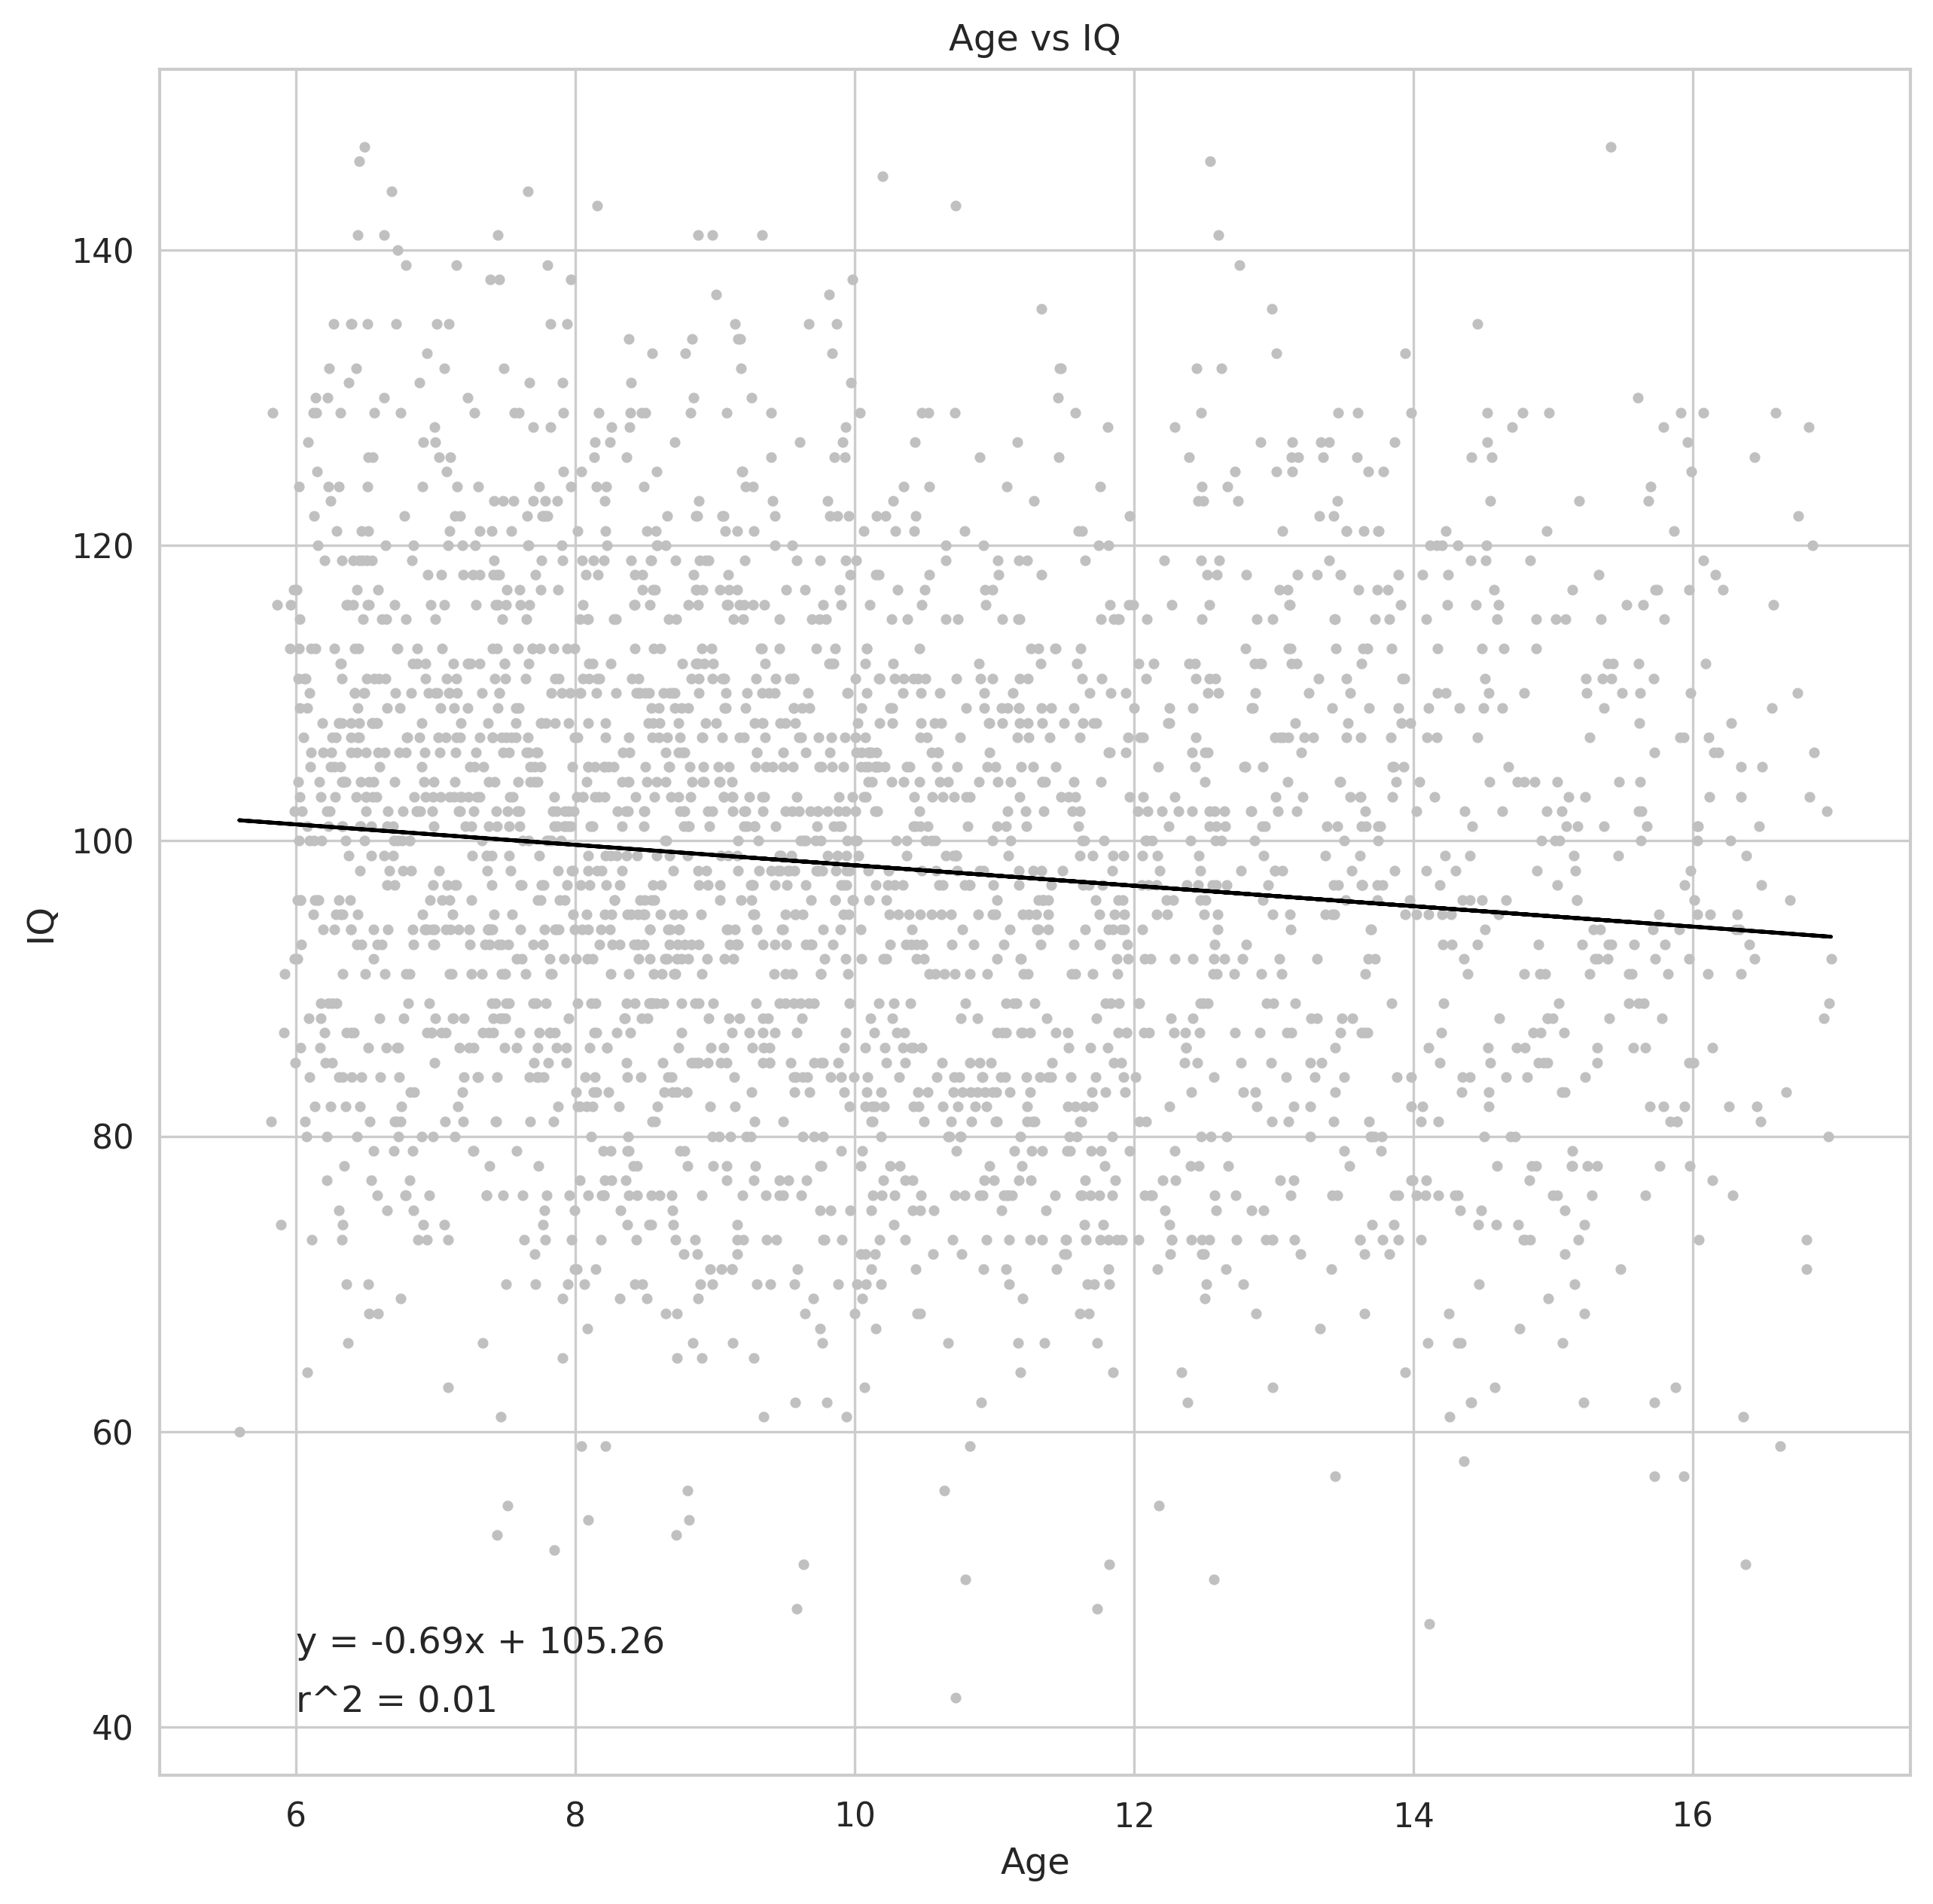

In [20]:
clean_labels = clean_labels.dropna(subset=['assessment WISC,WISC_FSIQ'])
wisc_fsiq = clean_labels['assessment WISC,WISC_FSIQ'].astype(int)
age = clean_labels['assessment Basic_Demos,Age'].astype(float)
print(age.shape, wisc_fsiq.shape, f"Avg IQ: {np.mean(wisc_fsiq)}")

m, b, r, p, stderr = stats.linregress(age, wisc_fsiq)
print(f"Slope: {m:.2f}, r2: {r**2:.2f}, p: {p:.2f}")

plt.plot(age, wisc_fsiq, '.', color='silver')
plt.plot(age, (m * age) + b, '-', color='black')
plt.title("Age vs IQ")
plt.xlabel('Age')
plt.ylabel('IQ')
plt.annotate(f"y = {m:.2f}x + {b:.2f}", (6, 45))
plt.annotate(f"r^2 = {r**2:.2f}", (6, 41))
plt.show()

## Power Atlas Labels

### Convert Power atlas to CSV and convert colors to Matplotlib

In [11]:
from common.paths import RAW_POWER, POWER

labels = pd.read_excel(RAW_POWER, index_col='ROI', dtype='str')
rois = labels.index

# Change colors to match matplotlib colors
color_key = {'Pale blue': 'lightsteelblue', 'Black': 'navy', 'Teal': 'lime'}
labels['Color'] = labels['Color'].replace(color_key)

print(f'Number of ROIs: {len(rois)}')

Number of ROIs: 264


In [13]:
labels.to_csv(POWER)